Discussed this assignment with Hyun In Park, Heeseung Hwang, and Sang Hoon Kim.

**Preliminary setup:**

In [1]:
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

f = open("labeled_small.json", "r")
data = pd.DataFrame(json.load(f))
f.close()


with open("vocab_30.json", "r") as f:
    vocab = json.load(f)
    f.close()
    
def binary_label(num):
    
    if num >= 14:
        return 1
    return 0

data["label"] = data["overall"].apply(binary_label)
data["review_set"] = data["review"].apply(lambda x: set(x.lower().split()))

**Part I: Data inspection**

In [2]:
brewer_list = data["brewer"].unique()
summary_brewer = dict()
std_list_brewer = []

beer_list = data["beer_id"].unique()
summary_beer = dict()
std_list_beer = []

for idnum in brewer_list:
    
    subset = data[data["brewer"] == idnum]["overall"]
    summary_brewer[idnum] = {"mean": np.mean(subset), "median": np.median(subset),
           "standard deviation": np.std(subset)}
    std_list_brewer.append(np.std(subset))

for idnum in beer_list:
    
    subset = data[data["beer_id"] == idnum]["overall"]
    summary_beer[idnum] = {"mean": np.mean(subset), "median": np.median(subset),
            "standard deviation": np.std(subset)}
    std_list_beer.append(np.std(subset))

Summary statistics of sample brewers (first 5 from the dictionary):

In [3]:
counter = 0
for brewer in summary_brewer:
    print("Brewer ID {:d}: mean {:.2f} median {:.2f} Std. deviation {:.2f}".format(
            int(brewer), summary_brewer[brewer]["mean"], summary_brewer[brewer]["median"], 
            summary_brewer[brewer]["standard deviation"]))
    counter += 1
    if counter == 5:
        break

Brewer ID 3084: mean 13.00 median 13.00 Std. deviation 2.54
Brewer ID 1786: mean 13.35 median 14.00 Std. deviation 2.36
Brewer ID 2528: mean 13.29 median 14.00 Std. deviation 3.01
Brewer ID 3704: mean 12.03 median 12.00 Std. deviation 2.92
Brewer ID 6438: mean 13.66 median 15.50 Std. deviation 4.78


Summary statistics of sample beers (first 5 from the dictionary):

In [4]:
counter = 0
for beer in summary_beer:
    print("Beer ID {:d}: mean {:.2f} median {:.2f} Std. deviation {:.2f}".format(
            int(beer), summary_beer[beer]["mean"], summary_beer[beer]["median"], 
            summary_beer[beer]["standard deviation"]))
    counter += 1
    if counter == 5:
        break

Beer ID 45842: mean 13.00 median 13.00 Std. deviation 0.00
Beer ID 95213: mean 14.00 median 14.00 Std. deviation 0.00
Beer ID 65957: mean 8.00 median 8.00 Std. deviation 0.00
Beer ID 41336: mean 16.00 median 16.00 Std. deviation 0.00
Beer ID 80424: mean 12.00 median 12.00 Std. deviation 0.00


Since there are approx. 400 brewers and 5,000 beers in the list, it is impractical to display summary statistics for each and all of them. (Summary statistics for some of them are given above, in order to show some sense of how those numbers are distributed. Those numbers are calculated for every brewer/beer, anyway). To see if people have (roughly) similar tastes, we need to see how standard deviation is distributed. (If people have similar tastes, they would have given similar ratings for a same beer / brewer, resulting in smaller standard deviation.)

In [5]:
np.mean(std_list_brewer)

2.038732137083195

In [6]:
np.mean(std_list_beer)

1.2784411724742057

From above, we can see that average standard deviation of overall ratings for brewers is ≈2.04 and for beers is ≈1.28. Given that the overall rating is in the scale of 0 to 20, these are quite small numbers (less than ≈10% of the scale length). Thus, we can guess that people (in particular, who have written reviews) have pretty similar tastes.

**Part II: Sentiment analysis**

**(a) Generating features**

In [7]:
docs = list(data["review_set"])
indptr = [0]
indices = []
info = []

for d in docs:
    
    indices.append(0)
    info.append(1)
    
    for term in d:
        
        if term in vocab:
            index = vocab[term] + 1      
            indices.append(index)
            info.append(1)
    
    indptr.append(len(indices)) #includes 1 for the intercept

In [8]:
csr_feature = csr_matrix((info, indices, indptr), dtype = int)
mat_data = data[["appearance", "aroma", "palate", "style", "taste", "label"]].to_numpy()

to_keep = []
for i in range(len(mat_data)):
    if np.count_nonzero(csr_feature[i].toarray()) > 1:
        to_keep.append(i)

csr_feature = csr_feature[to_keep, :]
mat_data = mat_data[to_keep, :]
csr_feature, mat_data = shuffle(csr_feature, mat_data, random_state = 1234)

cut1, cut2 = int(len(mat_data) * 0.7), int(len(mat_data) * 0.85)
train_data, train_feature = mat_data[:cut1], csr_feature[:cut1]
valid_data, valid_feature = mat_data[cut1:cut2], csr_feature[cut1:cut2]
test_data, test_feature = mat_data[cut2:], csr_feature[cut2:]

**(b) Logistic loss vs. Hinge loss**

In [9]:
#Logistic
logistic_loss, logistic_time = [], []

for c in [0.1, 1, 10, 100, 1000, 10000]:
    
    t_start = time.time()
    logistic = LogisticRegression(fit_intercept = False, C = c, penalty = "l2",
                                  multi_class = "multinomial", solver = "lbfgs") #training data already includes the intercept coordinate
    reg = logistic.fit(train_feature, list(train_data[:,-1]))
    t_end = time.time()
    
    logistic_time.append(t_end - t_start)
    error_count = 0
    
    for i in range(len(valid_data)):
        guess = np.argmax(reg.predict_proba(valid_feature[i].reshape(1, -1)))
        
        if guess != valid_data[i, -1]:
            error_count += 1
    
    logistic_loss.append(error_count / len(valid_data))

In [10]:
logistic_loss

[0.25335559265442403,
 0.2653756260434057,
 0.27813021702838064,
 0.28080133555926545,
 0.280534223706177,
 0.280534223706177]

In [11]:
logistic_time

[2.771204710006714,
 2.212934970855713,
 2.2966699600219727,
 2.2375519275665283,
 2.317929267883301,
 2.2177069187164307]

While the loss did not vary much across different values of C's, C = 0.1 yielded the lowest loss rate (0.2534). Thus, C = 0.1 would be the optimal here.  
Each model took somewhere between 2 to 3 seconds to fit, regardless of values of C.

In [12]:
#Hinge
hinge_loss, hinge_time = [], []

for c in [0.1, 1, 10, 100, 1000, 10000]:
    
    t_start = time.time()
    hinge = LinearSVC(penalty = "l2", loss = "hinge", C = c, fit_intercept = False)
    reg = hinge.fit(train_feature, train_data[:, -1])
    t_end = time.time()
    
    hinge_time.append(t_end - t_start)
    error_count = 0
    
    for i in range(len(valid_data)):
        guess = reg.predict(valid_feature[i].reshape(1, -1))

        if guess != valid_data[i,-1]:
            error_count += 1
            
    hinge_loss.append(error_count / len(valid_data))

In [13]:
hinge_loss

[0.2571619365609349,
 0.26631051752921536,
 0.2850751252086811,
 0.31819699499165277,
 0.34764607679465775,
 0.33509181969949914]

In [14]:
hinge_time

[1.3756818771362305,
 3.372706651687622,
 7.662633895874023,
 13.151164054870605,
 13.331754207611084,
 13.278854846954346]

Here, C = 0.1 yielded the optimal error rate (0.2572), and the error rate increased quite significantly as C increased.  
Also, while it took less than 2 seconds for fitting the model with C = 0.1, runtime rapidly grew as value of C increased.

**(c) Stochastic gradient descent**

In [15]:
def create_batch(x, y, size):
    
    batches = []
    entire = np.c_[x, y]
    np.random.shuffle(entire)
    num_batch = entire.shape[0] // size
    
    for i in range(num_batch + 1):
        
        minibatch = entire[i * size:(i + 1) * size, :]
        x_batch = minibatch[:, :-1]
        y_batch = minibatch[:, -1].reshape((-1, 1))
        batches.append((x_batch, y_batch))
    
    if data.shape[0] % size != 0:
        minibatch = entire[i * size:entire.shape[0]]
        x_batch = minibatch[:, :-1]
        y_batch = minibatch[:, :-1].reshape((-1, 1))
        batches.append((x_batch, y_batch))
    
    return batches

In [128]:
def SGD(x, y, delta, C, epoch, batch_size, decreasing_lr = False):
    
    theta = np.zeros(x.shape[1])
    batches = create_batch(x, y, batch_size)
    error_rate, neg_log_lik, counter = [], 0, 1
    
    for iter in range(epoch):
        
        for batch in batches:
            
            if len(batch[0]) >0:
                
                x_batch, y_batch = batch
                eta = np.dot(x_batch, theta) 
                predict = 1 / (1 + np.exp(-eta))      
                predict_cal =  predict > 0.5
                predict_cal = (predict_cal.astype(int) != y_batch)
                error_rate += [np.average(predict_cal)] * len(predict_cal)
                
                error = y_batch - predict - np.linalg.norm(theta) / C
            
                neg_log_lik += (-np.matmul(y_batch.T, eta) + np.sum(np.log(1 + np.exp(eta))))
            
                theta = theta + delta * np.average(error) * np.average(predict) * np.average(1 - predict) * x_batch.mean(0)
            
                if decreasing_lr:
                    delta /= (counter ** 0.5)
                    counter += 1
        
        neg_log_lik += np.sum(theta / C)
        
        return theta, np.average(error_rate), neg_log_lik[0]

In [17]:
train_test_x, train_test_y = train_feature[:3000].toarray(), train_data[:3000, -1]
valid_test_x, valid_test_y = valid_feature[:1500].toarray(), valid_data[:1500, -1]

In [24]:
fixed_val_error, dec_val_error = [], []

for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:

    fixed_theta, ferror, fnll = SGD(train_test_x, train_test_y, 0.005, c, 5, 10, False)
    dec_theta, derror, dnll = SGD(train_test_x, train_test_y, 0.02, c, 5, 10, True)
        
    guess_fixed = 1 / (1 + np.exp(-np.matmul(valid_test_x, fixed_theta)))
    guess_dec = 1 / (1 + np.exp(-np.matmul(valid_test_x, dec_theta)))
    
    guess_fixed = guess_fixed > 0.5
    guess_dec = guess_dec > 0.5
    guess_fixed, guess_dec = guess_fixed.astype(int), guess_dec.astype(int)
    
    guess_fixed = (guess_fixed != valid_test_y)
    guess_dec = (guess_dec != valid_test_y)
    
    fixed_val_error.append(np.average(guess_fixed))
    dec_val_error.append(np.average(guess_dec))
    

In [25]:
#empirical error rates (for both fixed and decreasing delta) differ for every execution due to random shuffling
fixed_val_error

[0.56, 0.56, 0.37866666666666665, 0.44, 0.44, 0.44, 0.44]

In [26]:
dec_val_error

[0.56, 0.44466666666666665, 0.56, 0.44, 0.56, 0.44, 0.556]

With the given number of iterations (epoch) and batch size, optimal value of C is tested with following conditions on learning rates:  
(1) fixed learning rate should be smaller than the initial value of the decreasing learning rate  
(2) decreasing learning rate should go lower than the fixed delta as SGD function iterates over epoch and batches.  
Also, learning rates are adjusted to quite small amounts after examining with relatively large values (e.g. 2), as large learning rates seemed to make the SGD process "too rapid."

Although the error rates differ every time executing code (some fluctuation due to random shuffling of data) and across different learning rates, it could be observed that fixed learning rate setup with C = 0.1 (i.e. $\lambda$ =  10) consistently yielded the lowest error rate on the validation set for the most of times. Therefore, I will assume that C = 0.1 with a fixed learning rate is the optimal hereafter.

In [86]:
train_and_val_label = np.r_[train_data, valid_data][:, -1]
train_and_val_feature = np.r_[train_feature, valid_feature]

neg_log_lik, error_rate, epoch = [], [], [1, 5, 10, 20, 50, 100, 200, 300, 500, 750, 1000]
test_set_error = []

for n in epoch:

    # increased batch size to mitigate the increase in runtime number of iterations grows to a large amount
    theta, error, nll = SGD(train_test_x, train_test_y, 0.005, 0.001, n, 500, False)
    neg_log_lik.append(nll)
    error_rate.append(error)
    
    test_eta = test_feature * theta
    predict = 1 / (1 + np.exp(-test_eta))
    predict = predict > 0.5
    predict = predict.astype(int)
    
    result = (predict != test_data[:, -1])
    test_set_error.append(np.average(result))

Error rate from running SGD with training+validation data:  
(x-axis: number of iterations / epoch)

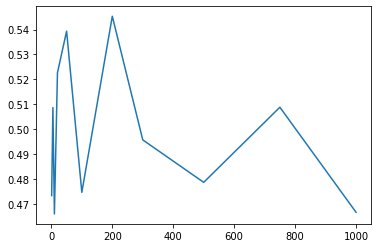

In [87]:
plt.plot(epoch, error_rate)
plt.show()

Negative log-likelihood from running SGD with training+validation data:  
(x-axis: number of iterations / epoch)

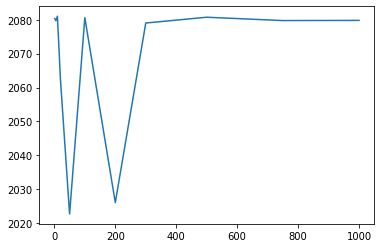

In [88]:
plt.plot(epoch, neg_log_lik)
plt.show()

Error rates on the testing set (with plot, x-axis being iterations):

In [90]:
test_set_error

[0.44714524207011686,
 0.44714524207011686,
 0.44714524207011686,
 0.5528547579298831,
 0.5528547579298831,
 0.44714524207011686,
 0.5528547579298831,
 0.5528547579298831,
 0.44714524207011686,
 0.44714524207011686,
 0.44714524207011686]

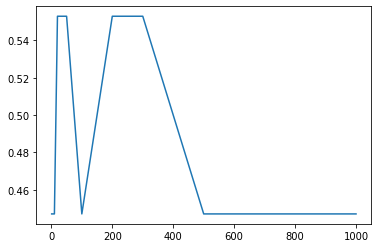

In [89]:
plt.plot(epoch, test_set_error)
plt.show()

Overall, these plots / negative log likelihood / error rates suggest a rough pattern of "convergence" through oscillation as number of iterations grow large.  

Comparing to the logistic loss and fitting time in part(b):  
In (b), fitting time and logistic loss did not have much correlation. (It rather had a correlation with C or $\lambda$). If we think number of iterations here as an equivalent concept to fitting time, while it shows some convergence, it does not necessarily show increasing / decreasing trend over epoch (i.e. it oscillates and there's no significant correlation). This observation matches the result of part (b).

**Part III: Score vs. text**

In [180]:
# train_data, valid_data, test_data matrices from above has
# label in its last column and score features for its other columns

# choosing the optimal C and between fixed / decreasing delta
fixed_score_error, dec_score_error = [], []

for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:

    fixed_theta, ferror, fnll = SGD(train_data[:3000, :-1], train_data[:3000, -1], 0.05, c, 10, 10, False)
    dec_theta, derror, dnll = SGD(train_data[:3000, :-1], train_data[:3000, -1], 2, c, 10, 10, True)
        
    guess_fixed = 1 / (1 + np.exp(-np.dot(valid_data[-1000:, :-1], fixed_theta)))
    guess_dec = 1 / (1 + np.exp(-np.dot(valid_data[-1000:, :-1], dec_theta)))
    
    guess_fixed = guess_fixed > 0.5
    guess_dec = guess_dec > 0.5
    guess_fixed, guess_dec = guess_fixed.astype(int), guess_dec.astype(int)
    guess_fixed = (guess_fixed != valid_data[-1000:, -1])
    guess_dec = (guess_dec != valid_data[-1000:, -1])
    
    fixed_score_error.append(np.average(guess_fixed))
    dec_score_error.append(np.average(guess_dec))

In [181]:
fixed_score_error

[0.564, 0.564, 0.564, 0.396, 0.436, 0.436, 0.572]

In [182]:
dec_score_error

[0.436, 0.436, 0.564, 0.436, 0.564, 0.564, 0.436]

By a similar method in part (b), optimal value of C is examined here. Although empirical error rates still differ by each execution and various learning rates setup, it could be observed that C = 1 with a fixed learning rate yielded the lowest error rate for the most of times.  
Thus, I will assume that C = 1 with a fixed delta to be optimal for score features.

In [214]:
#training a model using optimal parameters on the union of training & validation set

train_val_data = np.r_[train_data, valid_data]

# increased batch size to mitigate the increase in runtime
# due to greater data size and number of epoch

# By the "convergence" trend for more iterations, I will simply use the large epoch (1000)
theta, error, nll = SGD(train_val_data[:, :-1], train_val_data[:, -1], 0.05, 1, 1000, 100, False)
    
test_eta = np.dot(test_data[:, :-1], theta)
predict = 1 / (1 + np.exp(-test_eta))
predict = predict > 0.5
predict = predict.astype(int)
    
result = (predict != test_data[:, -1])
print(np.average(result))

0.5524540901502504


Reminder: the lowest error rate on the test set using text features were $\approx.0.45$.  

Although fluctuates per every execution due to the random shuffling effect, test set error rates were usually higher than 0.45 based on score features.  
Therefore, I would say that score features are less powerful in prediction than text features are.  

Intuitively, this would be due to the fact that score features are "ambiguously defined" quantification -- although people might be sure if they feel good or bad about taste / aroma / appearance, etc., numerical scale for the intensity of those feelings would depend very much on person. (i.e. even if two people were "equally satisfied" with aroma, one might give 20 while the other might give 15.)  
On the other hand, text features only capture whether or not certain words were used, and it does not involve quantification of sentiment degree. Therefore, it might have worked as fairer measure, free from biased numerical expression of feelings.